In [11]:
import requests
import cv2
import warnings
import urllib.request, json
import re
import http.client, urllib.request, urllib.parse, urllib.error, base64
import csv

import scholarly as slr
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from io import BytesIO
from math import ceil

# warnings.filterwarnings('ignore')

%matplotlib inline

ROWS = 1000

In [2]:
class ImageToFace:
    def __init__(self):
        # Model parameters
        dir_path = "/usr/local/Cellar/opencv/2.4.13.2/share/OpenCV/haarcascades"
        filename = "haarcascade_frontalface_default.xml" # for frontal faces
        #filename = "haarcascade_profileface.xml" # for profile faces
        model_path = dir_path + "/" + filename

        # Create the classifier
        self.clf = cv2.CascadeClassifier(model_path)
        
    def get_face(self, img):
        image = np.array(img.convert('RGB'))[:,:,::-1]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces on image
        faces = self.clf.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
        if len(faces) > 0:
            x, y, w, h = faces[0]
        else:
            return img
        
        return Image.fromarray(cv2.cvtColor(image[y:y+h, x:x+w], cv2.COLOR_BGR2RGB))
    
imtf = ImageToFace()

get_face = imtf.get_face

In [3]:
class FakeInfo:
    def __init__(self, name):
        self.name = name
        self.id = hash(name)
        self.url_picture = '/citations/images/avatar_scholar_128.jpg'
        
    def fill(self):
        self.publications = []

In [4]:
class GoogleNetwork:
    def __init__(self):
        self.id_info = {}
        self.name_id = {}
    
    def split_full_name(self, author_name):
        full_name = author_name.replace('.', '').split(' ')
        names, surname = full_name[:-1], full_name[-1]
        if len(names) == 1 and names[0].isupper():
            names = [ch for ch in names[0]]
        return names, surname
    
    def possible_names(self, names, surname):
        surnames = surname.split('-')
        result = []
        for surname in surnames:
            surname = surname.title()
            for name in names:
                result += [name+' '+surname, name[0]+' '+surname, name[0]+'. '+surname]
        return result
    
    def compare_name(self, name1, name2):
        if len(name1) > 1 and len(name2) > 1:
            return name1 in name2 or name2 in name1
        return name1[0] == name2[0]
    
    def compare_names(self, fullname1, fullname2):
        names1, surname1 = self.split_full_name(fullname1)
        names2, surname2 = self.split_full_name(fullname2)
        
        if '-' in surname1 or '-' in surname2:
            res = self.compare_names(surname1.replace('-', ' ') + "abc", surname2.replace('-', ' ') + "abc")
        else:
            res = self.compare_name(surname1, surname2)

        if res:
            ptr1, ptr2 = 0, 0
            
            while ptr1 < len(names1) and ptr2 < len(names2):
                if self.compare_name(names1[ptr1], names2[ptr2]):
                    ptr1 += 1
                    ptr2 += 1
                else:
                    if len(names1) - ptr1 == len(names2) - ptr2:
                        return False
                    if len(names1) - ptr1 > len(names2) - ptr2:
                        ptr1 += 1
                    else:
                        ptr2 += 1
            return True
            
        return False
    
    def get_info(self, author_name):
        names, surname = self.split_full_name(author_name)
        
        for name in self.possible_names(names, surname):
            if name in self.name_id:
                print('\t {} is already in the database.'.format(author_name))
                if author_name not in self.name_id:
                    for other_name in self.possible_names(names, surname):
                        self.name_id[other_name] = self.name_id[name]
                return self.id_info[self.name_id[name]]
        
        print('\t Searching {} in google scholar.'.format(author_name))
        full = False
        found = False
        for name in names:
            if len(name) > 1:
                full = True
                try:
                    query = slr.search_author(name+' '+surname)
                    while True:
                        author_info = next(query)
                        if self.compare_names(author_name, author_info.name):
                            found = True
                            break
                except:
                    continue
            if found:
                break
                
        if not found:
            if full:
                print('\t \t No match, creating fake id.')
                author_info = FakeInfo(author_name)
            else:
                try:
                    query = slr.search_author(surname)
                    while True:
                        author_info = next(query)
                        if self.compare_names(author_name, author_info.name):
                            break
                except:
                    print('\t \t No match, creating fake id.')
                    author_info = FakeInfo(author_name)

        print('\t Adding {} in database.'.format(author_name))

        self.id_info[author_info.id] = author_info

        for name in self.possible_names(names, surname):
            self.name_id[name] = author_info.id

        if author_name != author_info.name:
            for name in self.possible_names(*self.split_full_name(author_info.name)):
                self.name_id[name] = author_info.id
            
        return author_info
        
    def add_author(self, G, author_name):
        print('Adding {}:'.format(author_name))
        
        author_info = self.get_info(author_name)
        
        if author_info.id in G.nodes():
            print('\t Author id is already in the network.')            
            return
        
        print('\t Adding {} to network.'.format(author_name))
        G.add_node(author_info.id)
                
    def add_coauthors(self, G, author_name):
        print("Adding {}'s co-authors:".format(author_name))
        author_info = self.id_info[self.name_id[author_name]]
        author_id = author_info.id
        author_info.fill()
        
        coauthors = set()

        # Google Scholar
        print("\t Adding co-authors from Google Scholar")
        for pub in author_info.publications:
            pub.fill()
            coauthors = coauthors.union(pub.bib['author'].split(' and '))

        # Crossref
        print("\t Adding co-authors from Crossref")
        
        names, surname = self.split_full_name(author_name)
        with urllib.request.urlopen('https://api.crossref.org/works?query.author={}&rows=0'.format(surname)) as url:
            data = json.loads(url.read().decode())
        
        for i in range(ceil(data['message']['total-results'] / ROWS)):
            try:
                with urllib.request.urlopen(
                    'https://api.crossref.org/works?query.author={s}&rows={r}&offset={of}'.format(s=surname, r=ROWS,
                                                                                                 of=i*ROWS)) as url:
                    data = json.loads(url.read().decode())

            except:
                continue
                    
            for pub in data['message']['items']:
                for author in pub['author']:
                    try:
                        if surname in author['family']:
                            for name in names:
                                if len(name) > 1:
                                    if name in author['family'] or name in author['given']:
                                        for a in pub['author']:
                                            coauthors.add(a['given'] + ' ' + a['family'])
                    except:
                        continue
        
        # Microsoft Academic
        print("\t Adding co-authors from Microsoft Academic Knowledge")
        
        headers = {'Ocp-Apim-Subscription-Key': 'e2a75d980b2e4752bbe5e7f87fd72eea'}
        params = urllib.parse.urlencode({
            'expr': "Composite(AA.AuN='{}')".format(author_name.lower()),
            'attributes': 'AA.AuN'
        })

        try:
            conn = http.client.HTTPSConnection('westus.api.cognitive.microsoft.com')
            conn.request("GET", "/academic/v1.0/evaluate?%s" % params, "{body}", headers)
            response = conn.getresponse()
            data = response.read()
            conn.close()
        except Exception as e:
            print("[Errno {0}] {1}".format(e.errno, e.strerror))
            
        for match in re.finditer(b"\"AuN\"\:\"([\w ]+)\"", data):
            coauthors.add(match.group(1).decode().title())

        print()
        
        surnames = {}
        
        for name in coauthors:
            surname = name.replace('.', '').split(' ')[-1]
            if surname not in surnames or (len(surnames[surname]) < len(name) and 
                                           self.compare_names(name, surnames[surname])):
                surnames[surname] = name
        
        for surname in surnames:
            coauthor_info = self.get_info(surnames[surname])
            
            if coauthor_info.id != author_id:
                self.add_author(G, coauthor_info.name)
                print('\t Addind connection between {a} and {c}.\n'.format(a=author_name, c=coauthor_info.name))
                G.add_edge(author_id, coauthor_info.id)

In [5]:
G = nx.Graph()

In [6]:
gn = GoogleNetwork()

In [7]:
gn.add_author(G, 'Arseny Alexeev')

Adding Arseny Alexeev:
	 Searching Arseny Alexeev in google scholar.
	 Adding Arseny Alexeev in database.
	 Adding Arseny Alexeev to network.


In [ ]:
gn.add_coauthors(G, 'Anna Ott')

In [8]:
for i in G.neighbors_iter(gn.name_id['Arseny Alexeev']):
    print(gn.id_info[i].name)

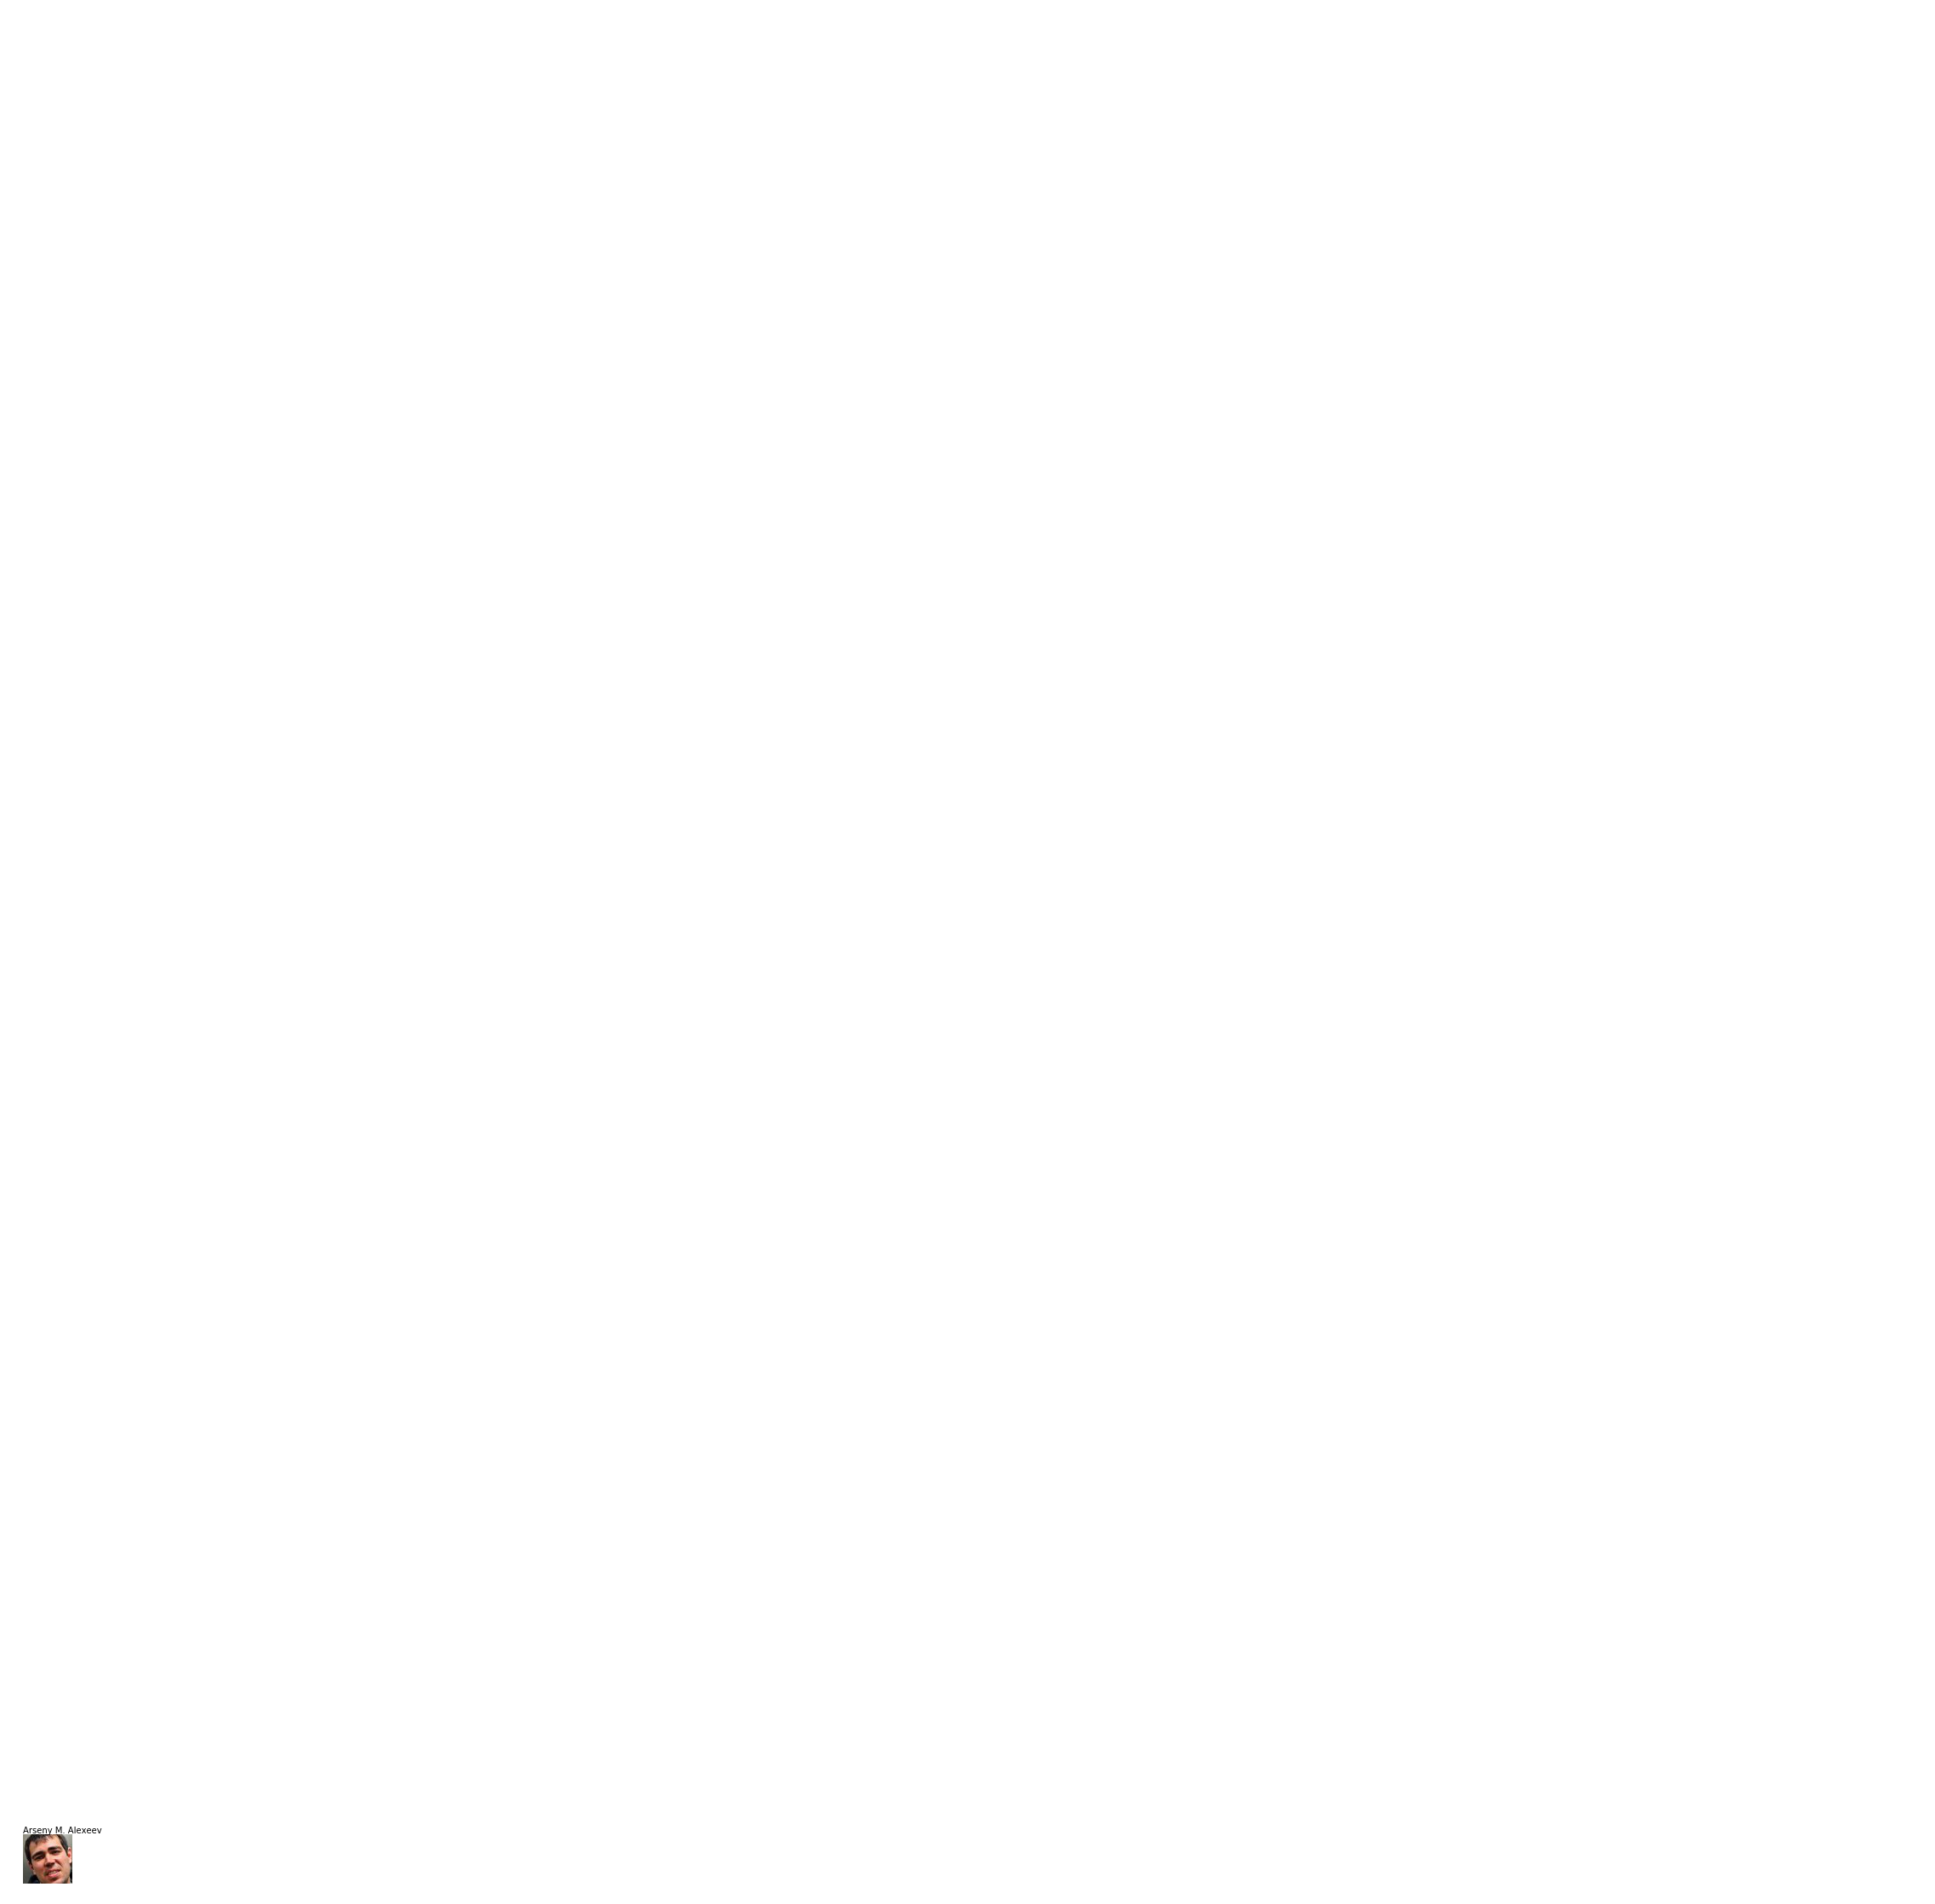

In [9]:
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(40,40))
ax = plt.subplot(111)
ax.set_aspect('equal')
nx.draw_networkx_edges(G, pos, ax=ax)

plt.axis('off')

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform

piesize = 0.02 # this is the image size
p2 = piesize / 2.0
for n in G:
    xx, yy = trans(pos[n]) # figure coordinates
    xa, ya = trans2((xx, yy)) # axes coordinates
    a = plt.axes([xa - p2, ya - p2, piesize, piesize])
    a.set_aspect('equal')
    response = requests.get('https://scholar.google.com' + gn.id_info[n].url_picture)
    img = Image.open(BytesIO(response.content))
    a.imshow(get_face(img))
    a.annotate(gn.id_info[n].name, xy=(0, 0), horizontalalignment='left', verticalalignment='bottom')
    a.axis('off')
    
plt.savefig('google-scholar-first-circle')

In [10]:
nx.write_graphml(G, 'network')

In [12]:
w = csv.writer(open("name_id.csv", "w"))
for key, val in gn.name_id.items():
    w.writerow([key, val])